# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [10]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [11]:
sales = graphlab.SFrame('kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [12]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [13]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [14]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.365113     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.383802     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.399427     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.439754     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.485728     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.514711     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [15]:
model_all.coefficients

name,index,value,stderr
(intercept),None,274873.05595,None
bedrooms,None,0.0,None
bedrooms_square,None,0.0,None
bathrooms,None,8468.53108691,None
sqft_living,None,24.4207209824,None
sqft_living_sqrt,None,350.060553386,None
sqft_lot,None,0.0,None
sqft_lot_sqrt,None,0.0,None
floors,None,0.0,None
floors_square,None,0.0,None


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen?

Ans: bathrooms, sqft_living, sqft_living_sqrt

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [44]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [71]:
import numpy as np
RSS=[]
for i in np.logspace(1, 7, num=13):
    model_all = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False,
                                              l2_penalty=0., l1_penalty=i)
    RSS.append(np.sum(np.square(model_all.predict(validation[all_features])-validation['price'])))


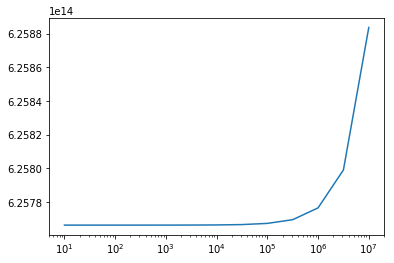

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.logspace(1, 7, num=13),RSS)
plt.xscale('log')

In [75]:
best_l1=np.logspace(1, 7, num=13)[RSS.index(min(RSS))]
best_l1

10.0

In [76]:
RSS

[625766285142460.5,
 625766285362394.0,
 625766286057885.2,
 625766288257224.9,
 625766295212186.1,
 625766317206080.6,
 625766386760658.2,
 625766606749278.8,
 625767302791635.1,
 625769507643885.9,
 625776517727024.5,
 625799062845466.6,
 625883719085425.4]

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

Ans: 10

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

Ans: All are non-zero

In [99]:
model_10 = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=10)
print model_10.coefficients.print_rows(100)

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
|    waterfront    |  None |  601905.594545   |  None  |
|       view       |  None |  93312.8573119   |  None  |
|    condition     |  None |  6609.03571245   |  None  |
|      grade       |  None |  6206.93999188   |  None  |
|    sqft_above    |  None |  4

In [117]:
model= graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=1e10)
sum(model.coefficients['value']!=0)

6L

In [120]:
type(model.coefficients['value'].nnz())

int

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [108]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [122]:
non_zero=[]
for i in l1_penalty_values:
    model= graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False,
                                              l2_penalty=0., l1_penalty=i)
    nzp=model.coefficients['value'].nnz()
    non_zero.append(nzp)
print non_zero

[18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 15, 15, 13, 12, 10, 6, 5, 3, 1, 1]


In [134]:
max_nonzeros=7
non_zero=np.array(non_zero)
boo=non_zero>max_nonzeros
leftindex=np.sum(boo)-1
rightindex=np.sum(boo)

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [138]:
l1_penalty_min = l1_penalty_values[leftindex]
l1_penalty_max = l1_penalty_values[rightindex]
print l1_penalty_min,",",l1_penalty_max 

2976351441.631313 , 3792690190.7322536


***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [139]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [153]:
RSS=[]
non_zero=[]

for i in l1_penalty_values:
    model= graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose = False,
                                              l2_penalty=0., l1_penalty=i)
    RSS.append(np.sum(np.square(model.predict(validation[all_features])-validation['price'])))
    nzp=model.coefficients['value'].nnz()
    non_zero.append(nzp)

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [155]:
non_zero

[10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6]

In [166]:
non_zero=np.array(non_zero)
leftindex=np.sum(non_zero>7)
rightindex=len(non_zero)-np.sum(non_zero<7)-1
print l1_penalty_values[leftindex],",",l1_penalty_values[rightindex]

3448968612.1634364 , 3577864204.126743
